# Installing the Packge
This notebook introduces the basics of using Bandits.jl package.

First install `MAB.jl` as below:

In [1]:
# import Pkg
# Pkg.add( "MAB" )

# Usage
To start using the package,

In [2]:
using MAB
using Statistics
using Plots

The package is divide into 3 sub modules:
* Algorithms
* Arms
* Experiments

`Algorithms` includes all the available algorithms. `Arms` includes the available arm model. `Experiments` is supposed to include code for running experiments and is a work under progress.

## Defining a bandit
For this demo, first we will create a bandit with 5 Bernoulli arms. It is not necessary to create a bandit with arms specified as below to use algorithms, but these kind of bandits can be used to benchmark new algorithms.
A bandit is an array of arms and can be defined as below:

In [3]:
bandit = [ Arms.Bernoulli(0.30),
            Arms.Bernoulli(0.40),
            Arms.Bernoulli(0.50),
            Arms.Bernoulli(0.60),
            Arms.Bernoulli(0.70)  ]

5-element Vector{MAB.Arms.Bernoulli}:
 MAB.Arms.Bernoulli(Distributions.Bernoulli{Float64}(p=0.3))
 MAB.Arms.Bernoulli(Distributions.Bernoulli{Float64}(p=0.4))
 MAB.Arms.Bernoulli(Distributions.Bernoulli{Float64}(p=0.5))
 MAB.Arms.Bernoulli(Distributions.Bernoulli{Float64}(p=0.6))
 MAB.Arms.Bernoulli(Distributions.Bernoulli{Float64}(p=0.7))

We can check the number of arms of the bandit as

In [4]:
no_of_arms = length( bandit )

5

So we have a 5-arm Bernoulli Bandit.

Each arm has 3 functions associated with it:
* `pull!()` - To pull an arm. Returns a reward associated with the arm. pull!() also changes the internal state of the arm if it is a Markovian/Non-stationary arms.
* `tick!()` - To change the internal state of a Markovian/Non-stationary arm. Not necessarily return something. May return junk depending on the internal state.
* `reset!()` - To reset the internal state of a Markovian/Non-stationary arm.

To pull an 1st arm,

In [5]:
Arms.pull!( bandit[1] )

true

In [6]:
fieldnames(epsGreedy)

(:noOfArms, :noOfSteps, :lastPlayedArm, :ϵ, :cummReward, :count, :avgValue)

Above line will randomly return 0/1 according to the underlying probability distribution.

## Using Algorithms
Every algorithm has specific initializers which depends on the parameters for the algorithms. Usually the first parameter of the initialization is the number of arms of the bandit. As an example, an instance of $\epsilon$-Greedy algorithm with $\epsilon = 0.10$ can be created as

In [7]:
epsGreedy( 5, 0.05 )


    noOfArms        : 5
    noOfSteps       : 0
    lastPlayedArm   : 0
    ϵ               : 0.05
    cummReward      : [0.0, 0.0, 0.0, 0.0, 0.0]
    count           : 

Algorithm: ϵ-Greedy (ϵ = 0.050)

[0, 0, 0, 0, 0]
    avgValue        : [0.0, 0.0, 0.0, 0.0, 0.0]

In [8]:
alg1 = epsGreedy( no_of_arms, 0.05 )

Algorithm: ϵ-Greedy (ϵ = 0.050)


    noOfArms        : 5
    noOfSteps       : 0
    lastPlayedArm   : 0
    ϵ               : 0.05
    cummReward      : [0.0, 0.0, 0.0, 0.0, 0.0]
    count           : [0, 0, 0, 0, 0]
    avgValue        : [0.0, 0.0, 0.0, 0.0, 0.0]

Now, let's run an experiment of $750$ timesteps and average it over $1000$ runs to get an average behaviour.

In [9]:
noOfRounds    = 1000
noOfTimesteps = 750

750

Create an array to hold the results of each round of play.

In [10]:
observations  = zeros( noOfTimesteps, noOfRounds );

Now we can run the $\epsilon$-Greedy algorithm over this bandit as below:

In [11]:
for _round = 1:noOfRounds
    reset!( alg1 )
    for arm ∈ bandit
        Arms.reset!( arm )
    end
    for _n = 1:noOfTimesteps
        armToPull = get_arm_index( alg1 )
        reward    = Arms.pull!( bandit[armToPull] )
        update_reward!( alg1, reward )
        observations[_n,_round] = reward
    end
end

Above code runs the algorithm for 250 time steps and save the obtained rewards into `observations`. Note that we need to `reset!()` the algorithm and arms between each rounds.

To see the average behaviour, we can plot the average reward.

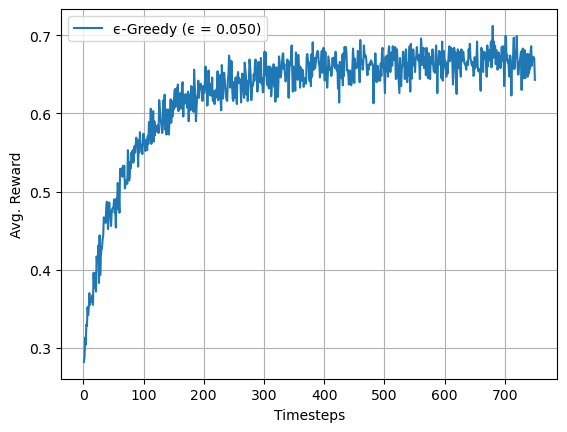

In [12]:
avgReward = mean( observations, dims = 2 )

using PyPlot
PyPlot.plot( 1:noOfTimesteps, avgReward, label = Algorithms.info_str(alg1) )
PyPlot.legend()
PyPlot.grid()
PyPlot.ylabel( "Avg. Reward" )
PyPlot.xlabel( "Timesteps" );

Congrats!! You have successfully completed the basics of Bandits.jl package. You can to the documentation page of the package to explore available algorithms and arm models.

# Comparing Multiple Algorithms
You can also compare performance of multiple algorithms easily with the package. First we'll look into the actual code for doing it. Later we will look into the `Experiments` section to automate this function.

As above, we'll start with defining a bandit

In [13]:
bandit1 = [ Arms.Bernoulli(0.25), Arms.Bernoulli(0.35), Arms.Bernoulli(0.45),
            Arms.Bernoulli(0.55), Arms.Bernoulli(0.65), Arms.Bernoulli(0.75) ]

no_of_arms = length( bandit1 )

6

We can define an array of algorithms which we want to test along the associated parameters as

In [14]:
test_algs = [ epsGreedy( no_of_arms, 0.10),
              epsGreedy( no_of_arms, 0.20),
              UCB1( no_of_arms ),
              TS( no_of_arms )    ];

We can run the experiment as:

In [15]:
fig = figure()

for _alg ∈ test_algs
    observations = zeros( noOfTimesteps, noOfRounds )
    for _r = 1:noOfRounds
        Algorithms.reset!( _alg )
        for _arm ∈ bandit1
            Arms.reset!( _arm )
        end
        for _n = 1:noOfTimesteps
            armToPull = Algorithms.get_arm_index( _alg )
            reward    = Arms.pull!( bandit1[armToPull] )
            Algorithms.update_reward!( _alg, reward )
            
            observations[_n,_r] = reward
        end
    end
    avgReward = mean( observations, dims =2 );
    PyPlot.plot( 1:noOfTimesteps, avgReward, label = Algorithms.info_str(_alg) )
end
PyPlot.ylabel( "Avg. Reward" )
PyPlot.xlabel( "Timesteps" )
PyPlot.title( "Comparison Plot (Averaged over $noOfRounds runs)" )
PyPlot.ax = gca()
PyPlot.ax[:set_ylim]( [0.00, 1.00] )
PyPlot.legend()
PyPlot.grid()

LoadError: No implementation of updateReward() for TS

You explore the above code by changing the bandit model and the algorithms to compare.